In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')
sns.set_palette('Set2')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score

In [2]:
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
data = pd.concat([train_data, test_data]).reset_index().drop(['index'], axis=1)

str_cols = data.select_dtypes(include=["object"]).columns
data[str_cols] = (data[str_cols]
                .apply(lambda s: s.str.strip())
                .replace(r"^\s*$", np.nan, regex=True))

if "Perished" in data and "Survived" not in data:
    data["Survived"] = 1 - data["Perished"]

In [3]:
data['Surname'] = data['Name'].apply(lambda x: x.split(',')[0])

In [4]:
# Ticket_id と Group_id の作成
data['Ticket_id'] = (data['Pclass'].astype(str) + '-' + 
                     data['Ticket'].str[:-1] + '-' + 
                     data['Fare'].astype(str) + '-' + 
                     data['Embarked'].astype(str))

data['Group_id'] = data['Surname'] + '-' + data['Ticket_id']

In [5]:
# Title特徴の作成
data['Title'] = 'man'
data.loc[data.Sex == 'female', 'Title'] = 'woman'
data.loc[data['Name'].str.contains('Master'), 'Title'] = 'boy'

In [6]:
# WCG (Woman-Child-Group) の識別
data.loc[data.Title == 'man', 'Group_id'] = 'noGroup'
data['WC_count'] = data.loc[data.Title != 'man'].groupby('Group_id')['Group_id'].transform('count')
data.loc[data.WC_count <=1, 'Group_id'] = 'noGroup'

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


In [7]:
# グループへの追加
indices = []
count = 0
for i in range(0,1309):
    if (data.loc[i,'Title'] != 'man') & (data.loc[i,'Group_id'] == 'noGroup'):
        matching = data.loc[(data['Ticket_id'] == data.loc[i, 'Ticket_id']) & (data.Title != 'man'), 'Group_id']
        if len(matching) > 0:
            data.loc[i,'Group_id'] = matching.iloc[0]
            if (data.loc[i, 'Group_id'] != 'noGroup'):
                indices.append(i)
                count += 1
print('{:d} passengers were added to an existing group'.format(count))

11 passengers were added to an existing group


In [8]:
# WCGの生存率
data['WCSurvived'] = data.loc[(data.Title != 'man') & (data.Group_id != 'noGroup')].groupby('Group_id').Survived.transform('mean')

In [9]:
# テストセットのみのグループ
test_groups = set(data[891:1309].Group_id.unique()) - set(data[0:891].Group_id.unique())
data.loc[data.Group_id.isin(test_groups), 'WCSurvived'] = 0
data.loc[(data.Group_id.isin(test_groups)) & (data.Pclass != 3), 'WCSurvived'] = 1

In [10]:
# WCGベースの初期予測
data.loc[891:1308, 'Predict'] = 0
data.loc[(data.index >= 891) & (data.index <= 1308) & (data.Sex == 'female'), 'Predict'] = 1
data.loc[(data.index >= 891) & (data.index <= 1308) & (data.Sex == 'female') & (data['WCSurvived'] == 0), 'Predict'] = 0
data.loc[(data.index >= 891) & (data.index <= 1308) & (data.Title == 'boy') & (data['WCSurvived'] == 1), 'Predict'] = 1

In [11]:
# 1人あたりの運賃
data['Ticket_freq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['Pfare'] = data['Fare'] / data['Ticket_freq']

## NEW: Pclass × Sex 組み合わせ特徴量

In [12]:
# Pclass と Sex を組み合わせた特徴量
data['Pclass_Sex'] = data['Pclass'].astype(str) + '_' + data['Sex']

print('=== Pclass_Sex の分布 ===')
print(data['Pclass_Sex'].value_counts())

print('\n=== 訓練データでの Pclass_Sex ごとの生存率 ===')
survival_by_pclass_sex = data[0:891].groupby('Pclass_Sex')['Survived'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(survival_by_pclass_sex)

=== Pclass_Sex の分布 ===
Pclass_Sex
3_male      493
3_female    216
1_male      179
2_male      171
1_female    144
2_female    106
Name: count, dtype: int64

=== 訓練データでの Pclass_Sex ごとの生存率 ===
                mean  count
Pclass_Sex                 
1_female    0.968085     94
2_female    0.921053     76
3_female    0.500000    144
1_male      0.368852    122
2_male      0.157407    108
3_male      0.135447    347


## 統合モデル: 全員（男性+女性）を一つのモデルで訓練

元のコードでは男性・女性を別々に訓練していたため、Sex情報が暗黙的でした。
今回は**全員を一つのモデル**で訓練し、`Pclass_Sex`で明示的に性別とクラスの交互作用を学習します。

In [13]:
# WCGに属さない人（男性+女性）を抽出
train_non_wcg = data[0:891].loc[data.WCSurvived.isnull()]
test_non_wcg = data[891:1309].loc[data.WCSurvived.isnull()]

print(f'Train non-WCG size: {len(train_non_wcg)}')
print(f'Test non-WCG size: {len(test_non_wcg)}')
print(f'\nTrain non-WCG survival rate: {train_non_wcg.Survived.mean():.3f}')
print(f'Male survival rate: {train_non_wcg[train_non_wcg.Sex=="male"].Survived.mean():.3f}')
print(f'Female survival rate: {train_non_wcg[train_non_wcg.Sex=="female"].Survived.mean():.3f}')

Train non-WCG size: 735
Test non-WCG size: 344

Train non-WCG survival rate: 0.337
Male survival rate: 0.160
Female survival rate: 0.818


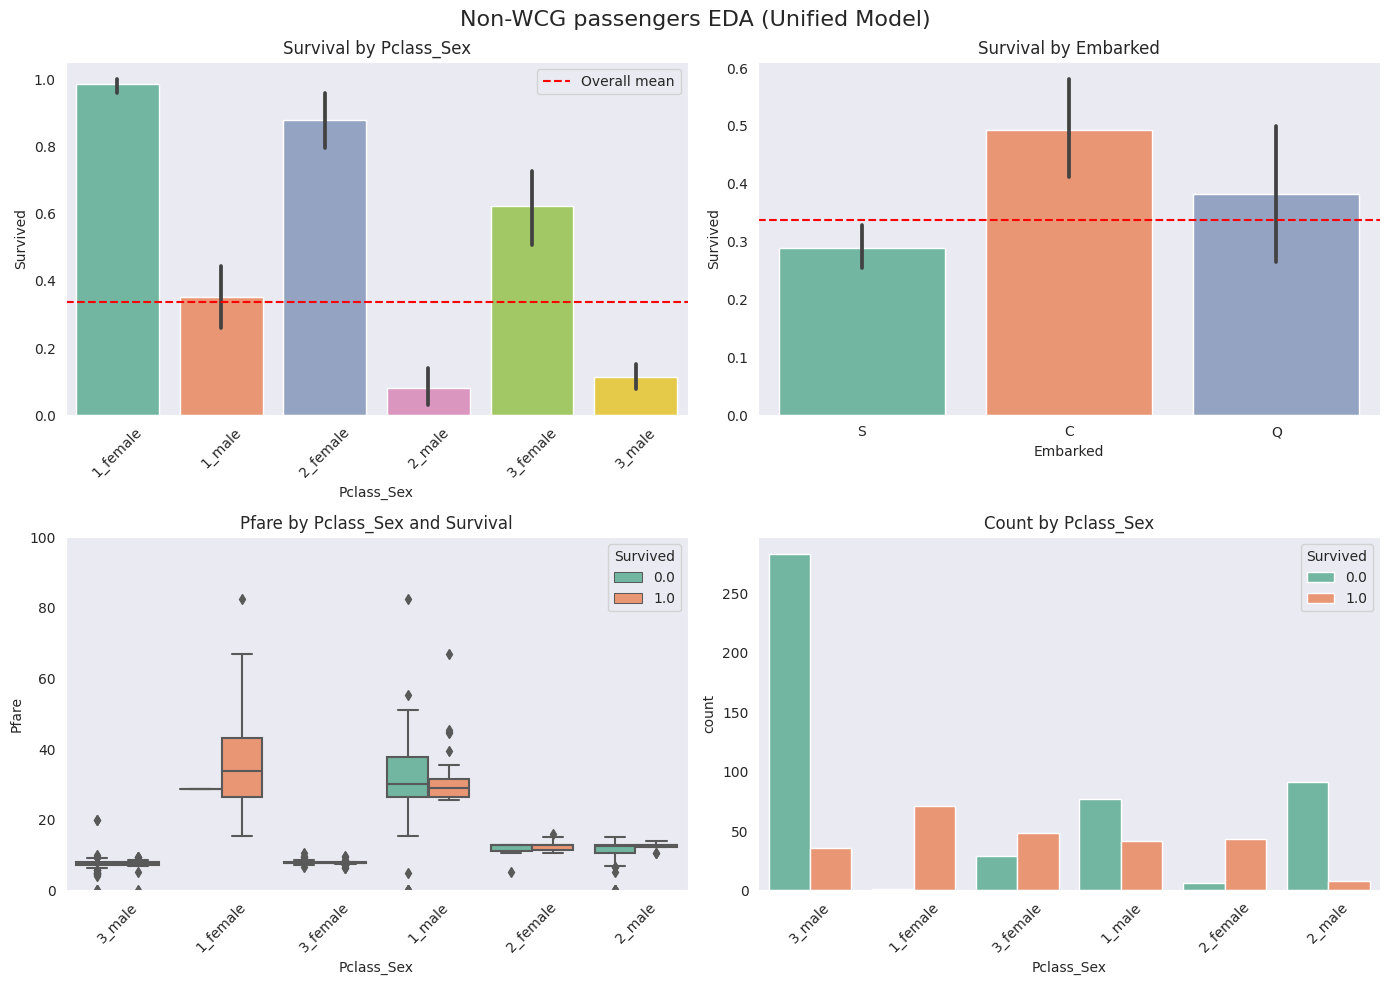

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Non-WCG passengers EDA (Unified Model)', fontsize=16)

sns.barplot(x='Pclass_Sex', y='Survived', data=train_non_wcg, ax=ax[0][0], order=sorted(train_non_wcg.Pclass_Sex.unique()))
ax[0][0].set_title('Survival by Pclass_Sex')
ax[0][0].tick_params(axis='x', rotation=45)
ax[0][0].axhline(y=train_non_wcg.Survived.mean(), color='r', linestyle='--', label='Overall mean')
ax[0][0].legend()

sns.barplot(x='Embarked', y='Survived', data=train_non_wcg, ax=ax[0][1])
ax[0][1].set_title('Survival by Embarked')
ax[0][1].axhline(y=train_non_wcg.Survived.mean(), color='r', linestyle='--')

sns.boxplot(x='Pclass_Sex', y='Pfare', hue='Survived', data=train_non_wcg, ax=ax[1][0])
ax[1][0].set_title('Pfare by Pclass_Sex and Survival')
ax[1][0].tick_params(axis='x', rotation=45)
ax[1][0].set_ylim(0, 100)

sns.countplot(x='Pclass_Sex', hue='Survived', data=train_non_wcg, ax=ax[1][1])
ax[1][1].set_title('Count by Pclass_Sex')
ax[1][1].tick_params(axis='x', rotation=45)

plt.tight_layout()

In [15]:
# 特徴量の設定: Pclass_Sex を使用（Age除外）
features = ['Pfare', 'Pclass_Sex', 'Embarked']

y_train = train_non_wcg['Survived']
X_train = train_non_wcg[features]
X_test = test_non_wcg[features]

numerical_cols = ['Pfare']
categorical_cols = ['Pclass_Sex', 'Embarked']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

print('Features used:', features)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Features used: ['Pfare', 'Pclass_Sex', 'Embarked']
X_train shape: (735, 3)
X_test shape: (344, 3)



Best k: 6 (Accuracy: 0.843)


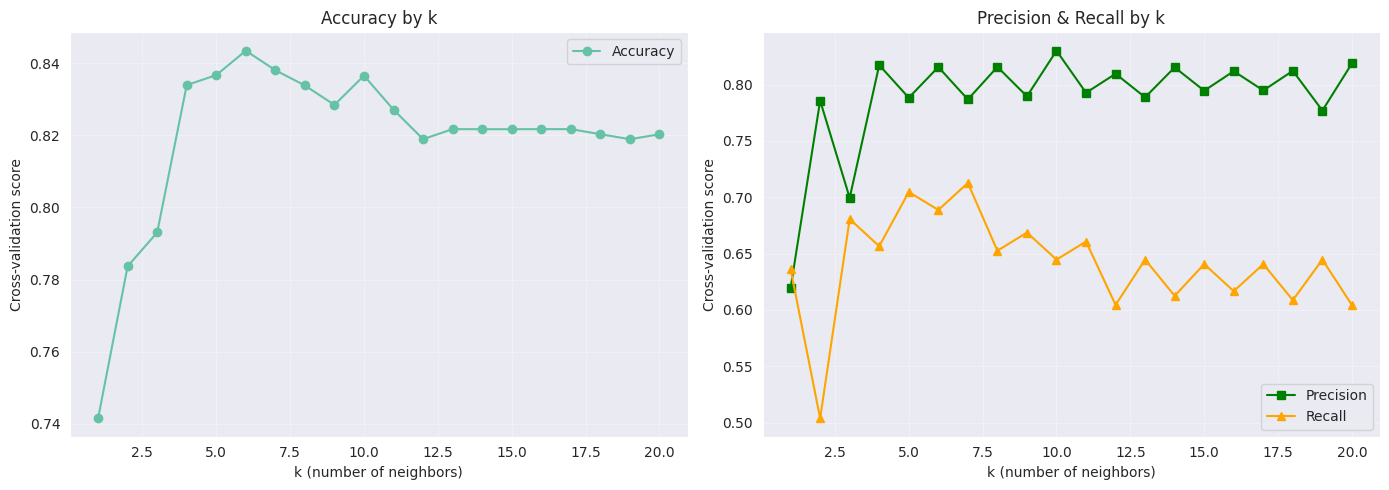

In [16]:
# KNNのkパラメータチューニング
accuracy_scores = []
precision_scores = []
recall_scores = []

k_range = range(1, 21)

for k in k_range:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    accuracy_scores.append(cross_val_score(pipeline, X_train, y_train, cv=10, n_jobs=-1).mean())
    precision_scores.append(cross_val_score(pipeline, X_train, y_train, cv=10, n_jobs=-1, scoring='precision').mean())
    recall_scores.append(cross_val_score(pipeline, X_train, y_train, cv=10, n_jobs=-1, scoring='recall').mean())

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(k_range, accuracy_scores, marker='o', label='Accuracy')
ax[0].set_xlabel('k (number of neighbors)')
ax[0].set_ylabel('Cross-validation score')
ax[0].set_title('Accuracy by k')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

ax[1].plot(k_range, precision_scores, marker='s', label='Precision', color='green')
ax[1].plot(k_range, recall_scores, marker='^', label='Recall', color='orange')
ax[1].set_xlabel('k (number of neighbors)')
ax[1].set_ylabel('Cross-validation score')
ax[1].set_title('Precision & Recall by k')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()

best_k = k_range[np.argmax(accuracy_scores)]
print(f'\nBest k: {best_k} (Accuracy: {max(accuracy_scores):.3f})')

In [17]:
# アンサンブルモデル
knn1 = KNeighborsClassifier(n_neighbors=3)
knn2 = KNeighborsClassifier(n_neighbors=5)
knn3 = KNeighborsClassifier(n_neighbors=9)

unified_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting', VotingClassifier([
        ('knn1', knn1), 
        ('knn2', knn2), 
        ('knn3', knn3)
    ]))
])

# クロスバリデーション
cv_results = cross_validate(
    unified_pipeline, X_train, y_train, cv=10,
    scoring=['accuracy', 'precision', 'recall'],
    return_train_score=True
)

print('=' * 70)
print('UNIFIED MODEL PERFORMANCE (10-Fold Cross-Validation)')
print('=' * 70)
print(f'Accuracy:  {cv_results["test_accuracy"].mean():.4f} (+/- {cv_results["test_accuracy"].std():.4f})')
print(f'Precision: {cv_results["test_precision"].mean():.4f} (+/- {cv_results["test_precision"].std():.4f})')
print(f'Recall:    {cv_results["test_recall"].mean():.4f} (+/- {cv_results["test_recall"].std():.4f})')
print('=' * 70)

UNIFIED MODEL PERFORMANCE (10-Fold Cross-Validation)
Accuracy:  0.8326 (+/- 0.0404)
Precision: 0.7833 (+/- 0.0589)
Recall:    0.6967 (+/- 0.1052)


In [18]:
# モデルの訓練と予測
unified_pipeline.fit(X_train, y_train)
predictions_non_wcg = unified_pipeline.predict(X_test)

# 予測結果の統計
print('=== Test Predictions (Non-WCG passengers) ===')
print(f'Total: {len(predictions_non_wcg)}')
print(f'Predicted to survive: {sum(predictions_non_wcg)} ({sum(predictions_non_wcg)/len(predictions_non_wcg)*100:.1f}%)')
print(f'Predicted to die: {len(predictions_non_wcg)-sum(predictions_non_wcg)} ({(len(predictions_non_wcg)-sum(predictions_non_wcg))/len(predictions_non_wcg)*100:.1f}%)')

# 性別ごとの予測
test_non_wcg_copy = test_non_wcg.copy()
test_non_wcg_copy['Prediction'] = predictions_non_wcg
print('\n=== Predictions by Pclass_Sex ===')
pred_summary = test_non_wcg_copy.groupby('Pclass_Sex')['Prediction'].agg(['sum', 'count', 'mean'])
pred_summary.columns = ['Survived', 'Total', 'Survival_Rate']
print(pred_summary.sort_values('Survival_Rate', ascending=False))

=== Test Predictions (Non-WCG passengers) ===
Total: 344
Predicted to survive: 98.0 (28.5%)
Predicted to die: 246.0 (71.5%)

=== Predictions by Pclass_Sex ===
            Survived  Total  Survival_Rate
Pclass_Sex                                
1_female        36.0     36       1.000000
2_female        15.0     15       1.000000
3_female        40.0     46       0.869565
1_male           6.0     55       0.109091
3_male           1.0    131       0.007634
2_male           0.0     61       0.000000


In [19]:
import os

# Predictの更新（WCGに属さない人の予測を上書き）
mask_non_wcg = (data.index >= 891) & (data.index <= 1308) & (data.WCSurvived.isnull())
data.loc[mask_non_wcg, 'Predict'] = predictions_non_wcg

# Survived形式 → Perished形式に変換
output = pd.DataFrame({
    'PassengerId': data[891:1309].PassengerId, 
    'Perished': (1 - data[891:1309].Predict).astype('int')
})

os.makedirs('../output', exist_ok=True)
output.to_csv('../output/knn_unified_pclass_sexxx.csv', index=False)

print('knn_unified_pclass_sex.csv was successfully saved!')
print('\n=== Model Features ===')
print('Features: Pfare, Pclass_Sex, Embarked')
print('Age: EXCLUDED')
print('Model: Unified (both male & female together)')
print('Pclass_Sex: Explicit interaction between Pclass and Sex')

knn_unified_pclass_sex.csv was successfully saved!

=== Model Features ===
Features: Pfare, Pclass_Sex, Embarked
Age: EXCLUDED
Model: Unified (both male & female together)
Pclass_Sex: Explicit interaction between Pclass and Sex


In [20]:
# 予測結果の詳細確認
print('=== Final Prediction Summary ===')
print(f'Total test passengers: {len(output)}')
print(f'\nPredicted Perished=1 (died): {(output["Perished"] == 1).sum()}')
print(f'Predicted Perished=0 (survived): {(output["Perished"] == 0).sum()}')
print(f'\nSurvival rate: {(output["Perished"] == 0).sum() / len(output) * 100:.2f}%')

# WCG予測と統合モデル予測の内訳
wcg_survived = ((data[891:1309].WCSurvived.notna()) & (data[891:1309].Predict == 1)).sum()
wcg_died = ((data[891:1309].WCSurvived.notna()) & (data[891:1309].Predict == 0)).sum()
model_survived = ((data[891:1309].WCSurvived.isna()) & (data[891:1309].Predict == 1)).sum()
model_died = ((data[891:1309].WCSurvived.isna()) & (data[891:1309].Predict == 0)).sum()

print('\n=== Breakdown by Prediction Method ===')
print(f'WCG-based survived: {wcg_survived}')
print(f'WCG-based died: {wcg_died}')
print(f'Model-based survived: {model_survived}')
print(f'Model-based died: {model_died}')

=== Final Prediction Summary ===
Total test passengers: 418

Predicted Perished=1 (died): 272
Predicted Perished=0 (survived): 146

Survival rate: 34.93%

=== Breakdown by Prediction Method ===
WCG-based survived: 48
WCG-based died: 26
Model-based survived: 98
Model-based died: 246
